# Technical Paper:
# Text Mining and Document Classification Workflows for Chinese Administrative Documents

## File 5.3.a2 - Support Vector Machine

This file goes through a workflow of model training and prediction with linear Support Vector Machines. It uses a resource-efficient combination of data (fastText encoded with 300 features) and algorithm.


## 1. Load packages and data

In [ ]:
import os
import numpy as np
import pandas as pd 
import random
import joblib
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [ ]:
# Machine learning
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [3]:
# Set seeds for reproducability
np.random.seed(421)
random.seed(421)

In [ ]:
# set working directory
os.chdir("working_directory")

In [5]:
# Load Y
y_train = pd.read_csv('./y_broad/y_broad_train.csv')['y_broad']
y_test = pd.read_csv('./y_broad/y_broad_test.csv')['y_broad']

In [26]:
# Load Fasttext data
x_train = pd.read_csv('./y_broad/train_embeddedFT_300.csv', header=None).to_numpy()
x_test = pd.read_csv('./y_broad/test_embeddedFT_300.csv', header=None).to_numpy()
x_unlabelled = pd.read_csv('unlabelled_embeddedFT1.csv', header=None).to_numpy()

In [27]:
# check data dimensions
x_train.shape, x_test.shape, x_unlabelled.shape

((13576, 300), (6688, 300), (993526, 300))

## 4.2 Pre-processing
### 4.2.1 Feature selection

The feature selection approach relies on a Support Vector Machine (SVM) with a L1 penalty to shrink coefficients to 0 that do not affect the outcome at all, depending on the regularization parameter C. The lower the parameter C, the fewer features remain.

In [8]:
# SVM model with penalty
lsvc = LinearSVC(C=1,
                 penalty="l1", 
                 dual=False,
                 random_state=421,
                 max_iter = 10000)
model = SelectFromModel(lsvc).fit(x_train, y_train)

In [29]:
# Prepare the data
x_train_transformed = pd.DataFrame(model.transform(x_train))
x_test_transformed = pd.DataFrame(model.transform(x_test))
x_unlabelled_transformed = pd.DataFrame(model.transform(x_unlabelled))

In [30]:
# check the dimensions
x_train_transformed.shape, x_test_transformed.shape , x_unlabelled_transformed.shape

((13576, 220), (6688, 220), (993526, 220))

### 4.2.2 Upsampling

Due to the imbalanced distribution of the response, the training data is upsampled to ensure training on a balanced distribution. The test data retains the imbalanced distribution.

In [12]:
# Select the minority class samples
minority_class_samples = x_train_transformed[y_train == 1]

# Extract the corresponding labels for the minority class samples.
minority_class_labels = y_train[y_train == 1]

# Upsample the minority class to match the majority class
X_upsampled, y_upsampled = resample(minority_class_samples, # upsample the minority class samples 
                                    minority_class_labels, # upsample labels 
                                    replace=True, # add more to the original number of samples
                                    n_samples=x_train_transformed[y_train == 0].shape[0], # The n_samples argument specifies the desired number of samples, which is set to the number of samples in the majority class.
                                    random_state=123) # The random_state=123 sets a seed for reproducibility.

# Put dataframes together again
x_bal_transformed = np.vstack((x_train_transformed[y_train == 0], X_upsampled))
y_bal = np.hstack((y_train[y_train == 0], y_upsampled))

In [13]:
# check the dimensions
x_bal_transformed.shape, y_bal.shape

((25612, 220), (25612,))

### 4.2.3 Dimensionality reduction

The fastText vectors may correlate to some extent, so Principal Component Analysis 

In [31]:
# standardize the vectors before PCA
scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse matrices
x_bal_scaled = scaler.fit_transform(x_bal_transformed)
x_test_scaled = scaler.fit_transform(x_test_transformed)
x_unlabelled_scaled = scaler.fit_transform(x_unlabelled_transformed)

In [32]:
# Coinfigure PCA
pca = PCA(n_components=0.95, random_state=421)  # Retain 95% variance

In [33]:
# Apply PCA
x_bal_pca = pca.fit_transform(x_bal_scaled)
x_test_pca = pca.transform(x_test_scaled)
x_unlabelled_pca = pca.transform(x_unlabelled_scaled)

In [34]:
# check the dimensions
x_bal_pca.shape, x_test_pca.shape, x_unlabelled_pca.shape

((25612, 155), (6688, 155), (993526, 155))

 ## 4.3 Linear Support Vector Machine

 The linear SVM fits a L2 penalty by default. The C parameter was determined via a grid search.

In [19]:
## configure first classifier
svm_classifier = SVC(kernel = 'linear', C = 9, random_state = 421)

In [20]:
# fit model with PCA data
Model2 = svm_classifier.fit(x_bal_pca, y_bal)

In [21]:
# predict on test set
y_test_pred = Model2.predict(x_test_pca)

In [35]:
# Estimation
print('Test data accuracy: %.3f' % Model2.score(x_test_pca, y_test))

Test data accuracy: 0.885


In [ ]:
# Evaluate the model 
print(metrics.classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      6308
           1       0.31      0.87      0.46       380

    accuracy                           0.88      6688
   macro avg       0.65      0.88      0.70      6688
weighted avg       0.95      0.88      0.91      6688



In [37]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
print(cm)

[[5586  722]
 [  50  330]]


Confusion Matrix:


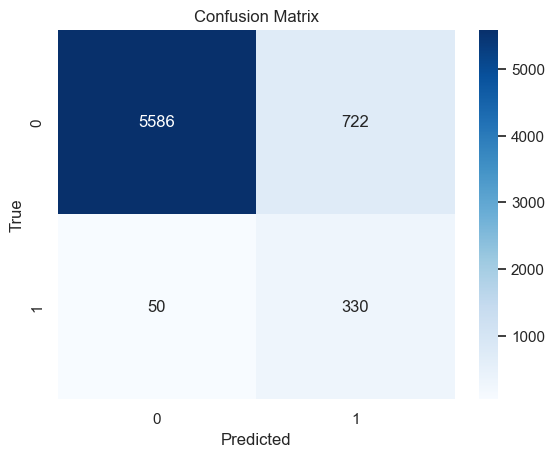

In [38]:
# Confusion matrix
confusion = confusion_matrix(y_true=y_test, y_pred=y_test_pred)

print("Confusion Matrix:")
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The model produces a large number of false positives (which are comparatively easy to eliminate), and a small number of false negatives (which are difficult to eliminate).

## 4.4 Prediction


In [ ]:
# load unlabelled data
data_unlabelled = pd.read_csv('./data_unlabelled_tok_fil.csv', converters={'tokenized_sen_filtered': literal_eval})
data_unlabelled

,doc_index,ran200doc,sentences,ran20sen,sen_index,tokenized_sen,tokenized_sen_filtered
0,1,137,《中外合资、合作医疗机构管理暂行办法》的补充规定 中华...,16,1,"[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ...","[中外合资, 合作医疗, 机构, 管理, 暂行办法, 补充规定, 中华人民共和国, 卫生部,..."
1,1,137,卫生部部长：陈竺商务部部长：陈德铭二○○七年十二月三十日 《中外合资、合作医疗机构管理暂行...,18,2,"['卫生部', '部长', '：', '陈竺', '商务部', '部长', '：', '陈德...","[卫生部, 部长, 陈竺, 商务部, 部长, 陈德铭, ○, ○, 七年, 十二月, 三十日..."
2,1,137,二、本规定中香港、澳门服务提供者应分别符合《内地与香港关于建立更紧密经贸关系的安排》及《...,18,3,"['\u3000', '\u3000', '二', '、', '本', '规定', '中',...","[规定, 香港, 澳门, 服务提供者, 应, 符合, 内地, 香港, 建立, 紧密, 经贸关..."
3,1,137,三、香港、澳门服务提供者在内地设立合资、合作医疗机构的其他规定，仍参照《中外合资、合作医...,7,4,"['\u3000', '\u3000', '三', '、', '香港', '、', '澳门'...","[香港, 澳门, 服务提供者, 内地, 设立, 合资, 合作医疗, 机构, 规定, 参照, ..."
4,1,137,四、本规定自2008年1月1日起施行,16,5,"['\u3000', '\u3000', '四', '、', '本', '规定', '自',...","[规定, 日起, 施行]"
...,...,...,...,...,...,...,...
993521,31138,35,否则不予报销,7,1003131,"['否则', '不予', '报销']","[不予, 报销]"
993522,31138,35,第四章 附则 第二十四条 本技术方案从二00八年六月一日起统一执行，同时原制定的补偿方案作废,8,1003132,"['\u3000', '第四章', '\u3000', '附则', '\u3000', '\...","[第四章, 附则, 第二十四条, 技术, 方案, 八年, 六月, 一日, 统一, 执行, 原..."
993523,31138,35,第二十五条 本方案由龙胜各族自治县新型农村合作医疗管理办公室负责解释,9,1003133,"['\u3000', '\u3000', '第二十五条', '\u3000', '本', '...","[第二十五条, 方案, 龙胜各族自治县, 新型农村, 合作医疗, 管理, 办公室, 负责, 解释]"
993524,31139,91,龙胜各族自治县人民政府关于成立自治县“健康扶贫·医疗救助”公益基金管理工作领导小组的通知龙胜...,14,1003135,"['龙胜各族自治县', '人民政府', '关于', '成立', '自治县', '“', '健...","[龙胜各族自治县, 人民政府, 成立, 自治县, 健康, 扶贫, ·, 医疗, 救助, 公益..."


In [41]:
data_unlabelled['svm_predictions'] = Model2.predict(x_unlabelled_pca)
data_unlabelled['svm_predictions']

0         0
1         0
2         0
3         0
4         0
         ..
993521    0
993522    0
993523    0
993524    0
993525    0
Name: svm_predictions, Length: 993526, dtype: int64

In [ ]:
# Predict
data_unlabelled['svm_predictions'].value_counts()


svm_predictions
0    835404
1    158122
Name: count, dtype: int64

In [43]:
data_predictions = data_unlabelled.drop(['sentences', 'tokenized_sen', 'tokenized_sen_filtered'], axis = 1)
data_predictions

,doc_index,ran200doc,ran20sen,sen_index,svm_predictions
0,1,137,16,1,0
1,1,137,18,2,0
2,1,137,18,3,0
3,1,137,7,4,0
4,1,137,16,5,0
...,...,...,...,...,...
993521,31138,35,7,1003131,0
993522,31138,35,8,1003132,0
993523,31138,35,9,1003133,0
993524,31139,91,14,1003135,0


In [ ]:
# save
data_predictions.to_csv('data_predictions.csv', index=False)